In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import spacy

!pip install spacy

!python -m spacy download en_core_web_lg

In [2]:
nlp = spacy.load('en_core_web_lg')

In [3]:
def sent_tokenization(text):
    doc = nlp(text)
    sent = [i.text for i in doc.sents]
    return sent
def word_tokenization(text):
    doc = nlp(text)
    words = [word for word in doc]
    return words
def lemmatization(text):
    return [word.lemma_ for word in text]

from nltk import corpus
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.remove('but')
stop_words.remove('very')

def stopword_removal(text):
    return [word for word in text if str(word) not in stop_words]

In [4]:
import re

def cleaning(df):
    df['tokenized'] = df['Review'].apply(sent_tokenization)
    nested_list = [(df['review_id'][i],df['Name'][i],df['Date'][i],df['Type_of_review'][i],
                   df['Rating'][i],j)\
                  for i in range(df['tokenized'].shape[0])\
                  for j in df['tokenized'][i]   ]
    data = pd.DataFrame(nested_list,columns=['Review_id','Name','Date','Type_of_review','Rating','Sentence'])
    print(data.head())
    
    #lowercasing the sentence
    data['Sentence'] = data['Sentence'].apply(lambda sent:sent.lower())
    #removing the punctuations and numbers
    data['cleaned_sentence'] = data['Sentence'].apply(lambda sent:re.sub(r'[^A-Za-z\s]','',sent))
    #removing the extra whitespaces in between the text
    data['cleaned_sentence'] = data['cleaned_sentence'].apply(lambda sent:re.sub(r'\s+',' ',sent))
    #removing the extra whitespaces in front and end of text
    data['cleaned_sentence'] = data['cleaned_sentence'].apply(lambda sent:sent.strip())
    #converting the sentence into words
    data['words'] = data['cleaned_sentence'].apply(word_tokenization)
    #lemmitization
    data['words'] = data['words'].apply(lemmatization)
    #stopwords removal
    data['words'] = data['words'].apply(stopword_removal)
    data['merged_words'] = data['words'].apply(lambda word:' '.join(word))
    df_flagmatrix = map_topics(data['words'])
    flagmatrix,aggregate,data = sentiment_analysis(data,df_flagmatrix) 
    
    return df_flagmatrix,flagmatrix,data,aggregate
    

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def map_topics(word_column):
    
    df_flagmatrix = pd.DataFrame(0,index = range(len(word_column)),columns=map_words.keys())
    
    for index,words in enumerate(word_column):
        for topic,wordlist in map_words.items():
            if any(word in wordlist for word in words):
                df_flagmatrix.loc[index,topic]=1
                break
    return df_flagmatrix
    
def sentiment_analysis(df,df_flagmatrix):
    df['pos_scores'] = df['merged_words'].apply(lambda x:sia.polarity_scores(x)['pos'])
    df['neu_scores'] = df['merged_words'].apply(lambda x:sia.polarity_scores(x)['neu'])
    df['neg_scores'] = df['merged_words'].apply(lambda x:sia.polarity_scores(x)['neg'])
    df['compound_scores'] = df['merged_words'].apply(lambda x:sia.polarity_scores(x)['compound']*5)
    cs = pd.DataFrame(columns=['compound'])
    cs['compound']= df['merged_words'].apply(lambda x:sia.polarity_scores(x)['compound']*5)
    
    flagmatrix = df_flagmatrix.copy()
    for i in range(flagmatrix.shape[0]):
        for j in range(flagmatrix.shape[1]):
            if flagmatrix.iloc[i,j] ==1:
                flagmatrix.iloc[i,j] = flagmatrix.iloc[i,j]*cs.iloc[i,0]
                
    avg = []
    for col in range(flagmatrix.shape[1]):
        sum1 = n = 0
        for row in range(flagmatrix.shape[0]):
            if flagmatrix.iloc[row,col]!=0:
                n+=1
                sum1+=flagmatrix.iloc[row,col]
        if n!=0:
            avg.append(sum1/n)
        else:
            avg.append(0)
    
    topics = map_words.keys()
    avg = np.array(avg)
    aggregate = pd.DataFrame(avg.reshape(1,10),columns=topics)
    return flagmatrix,aggregate,df


In [6]:
map_words = {
    'Flight Booking': ['board', 'boarding', 'book', 'booking', 'cancel', 'cancellation', 'ticket',
        'confirm', 'confirmation', 'itinerary', 'reserve', 'reservation', 'change', 'modify',
        'details', 'update', 'status', 'availability','process', 'upgrade', 'downgrade','rebooking',
        'travel', 'plan', 'class','portal', 'online', 'app','details','email',
        'policy','voucher', 'date','modify'],
    'Staff Service': ['crew', 'attendant', 'friendly', 'staff', 'hostess', 'polite', 'answer',
        'behave', 'behavior', 'courteous', 'member', 'rude', 'attitude', 'cooperative',
        'unprofessional', 'helpful', 'kind', 'patient', 'assist', 'handle', 'responsive',
        'interaction', 'team', 'supportive', 'cheerful','trained', 'help',
        'assistance', 'professional', 'smile', 'efficient','personnel', 'respectful',
        'communication', 'handling', 'manager', 'greet', 'welcome', 'care',
        'empathy', 'issues', 'attentive', 'inform','instructions'],
    'Fare': ['economy', 'price', 'budget', 'charge', 'cheap', 'cost', 'fee', 'lowcost', 'money',
        'fare', 'amount', 'payment', 'value', 'expensive', 'discount', 'offer', 'deal', 'rate',
        'affordable', 'reasonable', 'competitive', 'costly', 'high', 'cost-effective', 'saving',
        'price-sensitive','economical','premium', 'low-fare', 'bargain','quote', 'hidden', 'extra',
        'affordable','high-cost', 'pricing-policy','inclusive', 'transparent'],
    'Food': ['breakfast', 'drink', 'food', 'meal', 'snack', 'veg', 'water', 'dinner', 'hospitality',
        'serve', 'beverage', 'refreshment', 'sandwich', 'cuisine', 'taste', 'menu','quantity','lunch'
        'variety', 'non-veg', 'spicy', 'dessert', 'appetizer', 'portion','flavor', 'delicious',
        'bland', 'healthy', 'juice','order','tea', 'coffee', 'milk','beef', 'vegetarian', 'vegan',
        'rice','bread','butter','peanut', 'limited', 'choices', 'meal-pack', 'packaging', 'offer'],
    'Flight Features': ['domestic', 'international','toilet', 'lounge', 'washroom', 'facility',
        'wifi', 'entertainment', 'screen','power', 'headphones', 'legroom', 
        'feature', 'amenity', 'cabin','interior', 'ambient', 'air-conditioning', 
        'recliner', 'aisle', 'lighting', 'TV','charger','design', 'privacy', 'music',
        'restroom','arrangement','windows','views','seatbelt','temperature','tablet',
        'display', 'upgrade','convenience', 'features'],
    'Cleanliness': ['dirty', 'clean', 'maintenance','hygiene', 'sanitary', 'neat', 'tidy', 'filthy',
        'spotless', 'fresh', 'organized', 'smell', 'stain', 'cleaner', 'disinfect',
        'hygienic', 'dust', 'odor', 'trash', 'messy', 'sanitize', 'germs','sterile', 'freshener',
        'mop', 'garbage', 'clutter', 'scrub', 'neatness', 'litter','shiny', 'health', 'proper',
        'disorder', 'bathroom', 'filth', 'dirty-smell','unhygienic', 'dust-free'],
    'Special Assistance': ['assistance', 'support', 'accessibility', 'priority',
        'wheelchair', 'oxygen', 'guide', 'aid', 'medical', 'escort', 'special',
        'mobility', 'elderly', 'disable', 'needs','arrangement','handicap','assist',
        'disability','infirm','accessible', 'provision', 'mobility', 'special-care','elder',
        'stress-free','concierge', 'navigation','inclusive'],
    'Customer Service': ['customer', 'service', 'call', 'support', 'response', 'issue', 'resolve', 'complaint',
        'feedback','query', 'helpdesk', 'contact','prompt', 'rating', 'review', 'call-center', 
        'unresolve', 'solve', 'dissatisfy', 'answer','assistance',
        'queries','solution'],
    'Time Management': ['arrival', 'arrive', 'delay', 'depart', 'departure', 'early', 'late',
        'later', 'schedule', 'time', 'wait', 'timing', 'punctual','timely', 'duration', 'on-time','timeliness',
        'postpone','overtime', 'late-arrival','sharp','delayed', 'estimated',
        'lateness', 'wait-time', 'quick', 'timed', 'early-departure', 'delays'],
    'Seat Comfort': ['comfortable', 'seat', 'uncomfortable', 'comfort', 'seating', 'cushion', 'adjust',
        'cramp', 'recline', 'padding', 'armrest','tight', 'backrest', 'footrest', 'design', 'soft',
        'angle', 'headrest', 'lean','front', 'rear', 'softness', 'comfort-level',
        'personal-space','cozy','fabric', 'smooth']
}


In [7]:
df1 = pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='alliance_air')
df1.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,Yash Biyani,23rd July 2024,['Not Verified'],1,['The airline unexpectedly cancelled the fligh...
1,2,Pradeep Manyam,29th April 2024,['Not Verified'],1,[' This flight has some bad history of cancel...
2,3,S Karheen,24th March 2024,['Trip Verified'],1,"["" I had the misfortune of booking my mother'..."
3,4,T Markabu,18th March 2024,['Trip Verified'],1,[' It was the worst flight ever I used in my ...
4,5,Ananya Arandula,13th March 2024,['Not Verified'],1,"[""Worst airline ever. Our round trip flights g..."


In [8]:
df_flagmatrix1,flagmatrix1,df1,alliance_air = cleaning(df1)
alliance_air

   Review_id         Name            Date    Type_of_review  Rating  \
0          1  Yash Biyani  23rd July 2024  ['Not Verified']       1   
1          1  Yash Biyani  23rd July 2024  ['Not Verified']       1   
2          1  Yash Biyani  23rd July 2024  ['Not Verified']       1   
3          1  Yash Biyani  23rd July 2024  ['Not Verified']       1   
4          1  Yash Biyani  23rd July 2024  ['Not Verified']       1   

                                            Sentence  
0  ['The airline unexpectedly cancelled the fligh...  
1  This not only caused inconvenience but further...  
2  However, the money that was already paid for h...  
3       Will never recommend this airline to anyone.  
4  If they cannot ensure reliable operations, thi...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,-0.981671,-0.537679,-0.505955,0.638333,0.535556,-0.809,-1.5445,-1.584575,-1.424675,1.839833


In [9]:
df2 = pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='air_india')
df2.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,Johanna Gomez,30th July 2024,['Not Verified'],1.0,[' Will never fly with Air India again. Itine...
1,2,C Ranaja,29th July 2024,['Trip Verified'],2.0,"["" If Air India has such lousy in-flight ente..."
2,3,Noel Francis Lukwaro,27th July 2024,['Not Verified'],1.0,"[' The plane was so old and broken, everythin..."
3,4,Ashna John,21st July 2024,['Not Verified'],1.0,"[""I requested to cancel my ticket and had to d..."
4,5,J Horsman,19th July 2024,['Not Verified'],1.0,[' The worst flight I have ever been on. I ha...


In [10]:
df_flagmatrix2,flagmatrix2,df2,air_india = cleaning(df2)
air_india

   Review_id           Name            Date    Type_of_review  Rating  \
0          1  Johanna Gomez  30th July 2024  ['Not Verified']     1.0   
1          1  Johanna Gomez  30th July 2024  ['Not Verified']     1.0   
2          1  Johanna Gomez  30th July 2024  ['Not Verified']     1.0   
3          1  Johanna Gomez  30th July 2024  ['Not Verified']     1.0   
4          1  Johanna Gomez  30th July 2024  ['Not Verified']     1.0   

                                            Sentence  
0           ['  Will never fly with Air India again.  
1  Itinerary was New Delhi to Gold Coast, stoppin...  
2  I confirmed multiple times that I did not have...  
3  I would only need to collect my luggage on the...  
4  What went wrong: - they charge premium prices ...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,-0.025817,0.424961,0.716912,0.603512,0.866753,-0.254863,0.367185,-0.451648,-0.568529,0.664519


In [11]:
df_flagmatrix2.sum(axis=0)

Flight Booking        2156
Staff Service         1871
Fare                   554
Food                  1048
Flight Features        884
Cleanliness            156
Special Assistance      40
Customer Service       538
Time Management        941
Seat Comfort           367
dtype: int64

In [12]:
df3 = pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='air_asia_india')
df3.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,V Bakshi,14th October 2023,['Trip Verified'],6,[' I had booked this fare at a very discounted...
1,2,G Oscar,22nd September 2023,['Trip Verified'],1,[' I travel at least four times a month and Ai...
2,3,Rahul Verma,16th September 2023,['Trip Verified'],10,[' Taking this opportunity to appreciate and t...
3,4,G Akron,8th September 2023,['Trip Verified'],1,"["" The worst airlines in the history of mankin..."
4,5,Sirajudeen Jawahar ali,3rd July 2023,['Trip Verified'],8,[' Would like to give big thumbs up to boardi...


In [13]:
df_flagmatrix3,flagmatrix3,df3,air_asia = cleaning(df3)
air_asia

   Review_id      Name               Date     Type_of_review  Rating  \
0          1  V Bakshi  14th October 2023  ['Trip Verified']       6   
1          1  V Bakshi  14th October 2023  ['Trip Verified']       6   
2          1  V Bakshi  14th October 2023  ['Trip Verified']       6   
3          1  V Bakshi  14th October 2023  ['Trip Verified']       6   
4          1  V Bakshi  14th October 2023  ['Trip Verified']       6   

                                            Sentence  
0  [' I had booked this fare at a very discounted...  
1  The check in experience was good, I had arrive...  
2  Post that I had noticed that the inbound was d...  
3  The crew were welcoming and this flight was no...  
4  During boarding I had noticed that a lot of pe...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,0.282127,1.246862,0.209821,0.953409,0.15265,3.592,1.239417,-0.533983,-0.417684,1.097632


In [14]:
df_flagmatrix3.sum(axis=0)

Flight Booking        187
Staff Service         122
Fare                   54
Food                   18
Flight Features        16
Cleanliness             1
Special Assistance      6
Customer Service       44
Time Management        58
Seat Comfort           29
dtype: int64

In [15]:
df4 = pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='air_india_express')
df4.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,Ravi Ranjan Singh,1st March 2025,['Trip Verified'],1.0,[' These are the worst service provider. My ...
1,2,Mohamed Anis,13th February 2025,['Trip Verified'],1.0,"["" I am writing to express my disappointment..."
2,3,Sunprova Borah,12th February 2025,['Trip Verified'],1.0,['\xa0 \xa0Airport team charged extra for the ...
3,4,Nilesh Jeurkar,11th February 2025,['Trip Verified'],1.0,[' My flight was scheduled for 15:45 from Mumb...
4,5,H Darshun,10th February 2025,['Trip Verified'],2.0,[' Garbage flight service of Air India expre...


In [16]:
df_flagmatrix4,flagmatrix4,df4,air_india_express= cleaning(df4)
air_india_express

   Review_id               Name            Date     Type_of_review  Rating  \
0          1  Ravi Ranjan Singh  1st March 2025  ['Trip Verified']     1.0   
1          1  Ravi Ranjan Singh  1st March 2025  ['Trip Verified']     1.0   
2          1  Ravi Ranjan Singh  1st March 2025  ['Trip Verified']     1.0   
3          1  Ravi Ranjan Singh  1st March 2025  ['Trip Verified']     1.0   
4          1  Ravi Ranjan Singh  1st March 2025  ['Trip Verified']     1.0   

                                            Sentence  
0         ['   These are the worst service provider.  
1  My flight was delayed to 6:40 PM initially fro...  
2        Now again my flight was delayed to 7:20 pm.  
3  I had a connecting Train to my hometown schedu...  
4  I have planned the ticket and my journey two m...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,-0.355955,0.213612,0.308412,0.67485,0.217855,-1.7695,-0.3115,-0.512844,-1.29685,-0.026518


In [17]:
df5 = pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='akasa')
df5.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,P Bajwa,2nd August 2024,['Trip Verified'],2,[' It was a horrible experience as a first tim...
1,2,Ashwini Lokanath,2nd August 2024,['Not Verified'],1,['I’m utterly disgusted with the service provi...
2,3,Shubhada Thakur,28th July 2024,['Trip Verified'],10,[' My grandfather traveled from Delhi to Mumb...
3,4,Yaswanthkumar Yaram,24th July 2024,['Not Verified'],1,[' Worst experience and flight delayed by 8hr...
4,5,Anushka Bhoir,15th July 2024,['Not Verified'],1,[' My recent experiences with Akasa Air have ...


In [18]:
df_flagmatrix5,flagmatrix5,df5,akasa= cleaning(df5)
akasa

   Review_id     Name             Date     Type_of_review  Rating  \
0          1  P Bajwa  2nd August 2024  ['Trip Verified']       2   
1          1  P Bajwa  2nd August 2024  ['Trip Verified']       2   
2          1  P Bajwa  2nd August 2024  ['Trip Verified']       2   
3          1  P Bajwa  2nd August 2024  ['Trip Verified']       2   
4          1  P Bajwa  2nd August 2024  ['Trip Verified']       2   

                                            Sentence  
0  [' It was a horrible experience as a first tim...  
1  I am frequent flyer and opted AKASA AIR SERVIC...  
2  I reached for check in at 15.10 and the Flight...  
3  They still had 45 minutes in their hands but n...  
4  Such a ruckus for all, 10 passengers were stan...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,-0.12536,0.849771,0.192226,-0.082654,1.8851,1.25455,1.399591,-0.141425,-0.456167,0.395045


In [19]:
df6 = pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='go_air')
df6.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,Gladson Daniel,26th November 2021,['Trip Verified'],1.0,[' They Simply cancelled the flight. Which af...
1,2,Aaron Dsouza,14th November 2021,['Not Verified'],1.0,"[' Pathetic front desk, impolite and worst sta..."
2,3,Deepak Saha,16th August 2021,['Trip Verified'],1.0,[' Worst Airline ever I have come across so f...
3,4,Pratheesh KR,5th August 2021,['Trip Verified'],1.0,"["" I arrived early for my scheduled flight Ko..."
4,5,R Heller,3rd August 2021,['Trip Verified'],1.0,[' I booked a flight on August 2nd for 4 memb...


In [20]:
df_flagmatrix6,flagmatrix6,df6,goair = cleaning(df6)
goair

   Review_id            Name                Date     Type_of_review  Rating  \
0          1  Gladson Daniel  26th November 2021  ['Trip Verified']     1.0   
1          1  Gladson Daniel  26th November 2021  ['Trip Verified']     1.0   
2          1  Gladson Daniel  26th November 2021  ['Trip Verified']     1.0   
3          1  Gladson Daniel  26th November 2021  ['Trip Verified']     1.0   
4          2    Aaron Dsouza  14th November 2021   ['Not Verified']     1.0   

                                            Sentence  
0              ['  They Simply cancelled the flight.  
1                Which affects all my vacation plan.  
2          No proper response from the airline team.  
3  When I tried to change the date of they are as...  
4  [' Pathetic front desk, impolite and worst sta...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,-0.61517,0.045716,-0.2485,0.806233,0.17175,1.516313,0.404438,-0.970839,-0.771581,-1.003781


In [21]:
df_flagmatrix6.sum(axis=0)

Flight Booking        485
Staff Service         181
Fare                   84
Food                   32
Flight Features        25
Cleanliness            10
Special Assistance     11
Customer Service      138
Time Management       149
Seat Comfort           29
dtype: int64

In [22]:
df7 = pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='go_first')
df7.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,G Mandal,2nd May 2023,['Trip Verified'],1,[' Cancelled the flight at last moment and rui...
1,2,Vishwanath Deshpande,2nd May 2023,['Not Verified'],1,[' The worst ever flight. They cancel your fli...
2,3,Akash Raval,2nd May 2023,['Trip Verified'],1,[' Worst airline. This is the 2nd time we hav...
3,4,K Gupta,2nd May 2023,['Trip Verified'],1,[' My flight got cancelled without any notific...
4,5,M Reddy,27th April 2023,['Trip Verified'],1,"["" Delaying flights by 5-6 hrs and changing th..."


In [23]:
df_flagmatrix7,flagmatrix7,df7,go_first = cleaning(df7)
go_first

   Review_id                  Name          Date     Type_of_review  Rating  \
0          1              G Mandal  2nd May 2023  ['Trip Verified']       1   
1          1              G Mandal  2nd May 2023  ['Trip Verified']       1   
2          2  Vishwanath Deshpande  2nd May 2023   ['Not Verified']       1   
3          2  Vishwanath Deshpande  2nd May 2023   ['Not Verified']       1   
4          2  Vishwanath Deshpande  2nd May 2023   ['Not Verified']       1   

                                            Sentence  
0  [' Cancelled the flight at last moment and rui...  
1  Beware of this type of airlines as now I try t...  
2                          [' The worst ever flight.  
3        They cancel your flight at the last moment.  
4  The cost of other flights would have jumped by...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,-0.811573,-0.405327,-0.601942,0.181125,0.82185,-0.4319,-0.326333,-1.428908,-1.041522,-0.348733


In [24]:
df_flagmatrix7.sum(axis=0)

Flight Booking        455
Staff Service         138
Fare                   70
Food                    7
Flight Features        14
Cleanliness             6
Special Assistance      6
Customer Service      105
Time Management       144
Seat Comfort           17
dtype: int64

In [25]:
df8=pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='indigo')
df8.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,Saramma Pa,2nd August 2024,['Not Verified'],1.0,['Worst Airline. Delayed first leg and missed ...
1,2,Manoj Jena,26th July 2024,['Trip Verified'],1.0,"["" This flight I missed due to airline ignora..."
2,3,Gaspard Grass,23rd June 2024,['Not Verified'],5.0,[' \xa0My Indigo flight 6E-11 DEL-IST on 17 ju...
3,4,Namrata Dubey,10th June 2024,['Trip Verified'],1.0,"["" My sister had flight today at 1:25 from Lu..."
4,5,L Gomil,9th June 2024,['Trip Verified'],1.0,"["" Worst experience. They are the worst staff..."


In [26]:
df_flagmatrix8,flagmatrix8,df8,indigo = cleaning(df8)
indigo

   Review_id        Name             Date     Type_of_review  Rating  \
0          1  Saramma Pa  2nd August 2024   ['Not Verified']     1.0   
1          1  Saramma Pa  2nd August 2024   ['Not Verified']     1.0   
2          1  Saramma Pa  2nd August 2024   ['Not Verified']     1.0   
3          2  Manoj Jena   26th July 2024  ['Trip Verified']     1.0   
4          2  Manoj Jena   26th July 2024  ['Trip Verified']     1.0   

                                            Sentence  
0                                   ['Worst Airline.  
1    Delayed first leg and missed connecting flight.  
2  Ground staff and counter staff worst attitude ...  
3  ["  This flight I missed due to airline ignora...  
4  First they declared gate 8 then they declared ...  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,0.370822,1.494451,0.697362,0.868867,1.222455,1.887148,0.855727,0.201706,-0.368744,0.698102


In [27]:
df_flagmatrix8.sum(axis=0)

Flight Booking        740
Staff Service         624
Fare                  258
Food                  172
Flight Features       125
Cleanliness            46
Special Assistance     24
Customer Service      135
Time Management       308
Seat Comfort          104
dtype: int64

In [28]:
df9=pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='spice_jet')
df9.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,K Mansour,21st July 2024,['Trip Verified'],10.0,[' I have had good service by the crew. It was...
1,2,A Kajan,18th July 2024,['Trip Verified'],10.0,"["" It's very grateful to SpiceJet for the ser..."
2,3,Satvir Singh,9th July 2024,['Trip Verified'],1.0,"[""\xa0 \xa0I have been waiting from 3 hours an..."
3,4,Z Hakira,6th July 2024,['Trip Verified'],3.0,[' I would not recommend SpiceJet as they fre...
4,5,A Masyan,6th July 2024,['Trip Verified'],1.0,[' It’s been 4th time already since my flight...


In [29]:
df_flagmatrix9,flagmatrix9,df9,spice_jet = cleaning(df9)
spice_jet

   Review_id       Name            Date     Type_of_review  Rating  \
0          1  K Mansour  21st July 2024  ['Trip Verified']    10.0   
1          1  K Mansour  21st July 2024  ['Trip Verified']    10.0   
2          1  K Mansour  21st July 2024  ['Trip Verified']    10.0   
3          2    A Kajan  18th July 2024  ['Trip Verified']    10.0   
4          2    A Kajan  18th July 2024  ['Trip Verified']    10.0   

                                            Sentence  
0            [' I have had good service by the crew.  
1  It was amazing, the crew was very enthusiastic...  
2  It was one of the best services in my experien...  
3  ["  It's very grateful to SpiceJet for the ser...  
4     Everything is fine with excellent hospitality.  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,-0.120884,0.67704,0.400866,0.438286,0.434225,0.392412,1.188357,-0.467216,-1.123785,0.310047


In [30]:
df_flagmatrix9.sum(axis=0)

Flight Booking        898
Staff Service         684
Fare                  260
Food                  174
Flight Features       103
Cleanliness            21
Special Assistance     25
Customer Service      239
Time Management       451
Seat Comfort           98
dtype: int64

In [31]:
df10=pd.read_excel('C:\\Users\\DELL\\Project\\NLP\\table1.xlsx',sheet_name='vistara')
df10.head()

,review_id,Name,Date,Type_of_review,Rating,Review
0,1,Vikas Verma,26th July 2024,['Trip Verified'],1,[' Extremely impolite and ill mannered cabin ...
1,2,M Saju,20th July 2024,['Trip Verified'],10,"[' It was really nice experience, this was my..."
2,3,P Reddy,12th June 2024,['Trip Verified'],6,"[' The on-ground experience was great, very pl..."
3,4,S Hunsel,12th June 2024,['Trip Verified'],7,[' A late night flight (10 pm) delayed by alm...
4,5,Kirti Dubey,9th June 2024,['Trip Verified'],1,"["" I faced a helpless situation with Vistara...."


In [32]:
df_flagmatrix10,flagmatrix10,df10,vistara = cleaning(df10)
vistara

   Review_id         Name            Date     Type_of_review  Rating  \
0          1  Vikas Verma  26th July 2024  ['Trip Verified']       1   
1          1  Vikas Verma  26th July 2024  ['Trip Verified']       1   
2          1  Vikas Verma  26th July 2024  ['Trip Verified']       1   
3          1  Vikas Verma  26th July 2024  ['Trip Verified']       1   
4          1  Vikas Verma  26th July 2024  ['Trip Verified']       1   

                                            Sentence  
0  ['  Extremely impolite and ill mannered cabin ...  
1  Instead of giving a reply to a simple question...  
2  Even his colleagues were visibly disturbed by ...  
3  Some people lack basic etiquettes and cannot b...  
4                         But does the airline care?  


,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
0,1.031403,1.683847,1.48575,2.31147,1.817416,2.42185,1.030038,1.203317,0.131712,1.645466


In [33]:
all_airlines = [air_india,air_asia,air_india_express,alliance_air,akasa,goair,go_first,indigo,spice_jet,vistara]
brand_names = ['air india','air asia','air india express','alliance air','akasa','goair','gofirst','indigo','spicejet','vistara']
airlines = pd.concat(all_airlines)
airlines.index = brand_names
round(airlines,4)

,Flight Booking,Staff Service,Fare,Food,Flight Features,Cleanliness,Special Assistance,Customer Service,Time Management,Seat Comfort
air india,-0.0258,0.4250,0.7169,0.6035,0.8668,-0.2549,0.3672,-0.4516,-0.5685,0.6645
air asia,0.2821,1.2469,0.2098,0.9534,0.1526,3.5920,1.2394,-0.5340,-0.4177,1.0976
air india express,-0.3560,0.2136,0.3084,0.6748,0.2179,-1.7695,-0.3115,-0.5128,-1.2968,-0.0265
alliance air,-0.9817,-0.5377,-0.5060,0.6383,0.5356,-0.8090,-1.5445,-1.5846,-1.4247,1.8398
akasa,-0.1254,0.8498,0.1922,-0.0827,1.8851,1.2546,1.3996,-0.1414,-0.4562,0.3950
goair,-0.6152,0.0457,-0.2485,0.8062,0.1718,1.5163,0.4044,-0.9708,-0.7716,-1.0038
gofirst,-0.8116,-0.4053,-0.6019,0.1811,0.8218,-0.4319,-0.3263,-1.4289,-1.0415,-0.3487
indigo,0.3708,1.4945,0.6974,0.8689,1.2225,1.8871,0.8557,0.2017,-0.3687,0.6981
spicejet,-0.1209,0.6770,0.4009,0.4383,0.4342,0.3924,1.1884,-0.4672,-1.1238,0.3100
vistara,1.0314,1.6838,1.4857,2.3115,1.8174,2.4219,1.0300,1.2033,0.1317,1.6455


In [34]:
#to save the file so that we can easily use these values for further analysis rather than running it everytime
airlines.to_excel('aggregate_scores.xlsx')

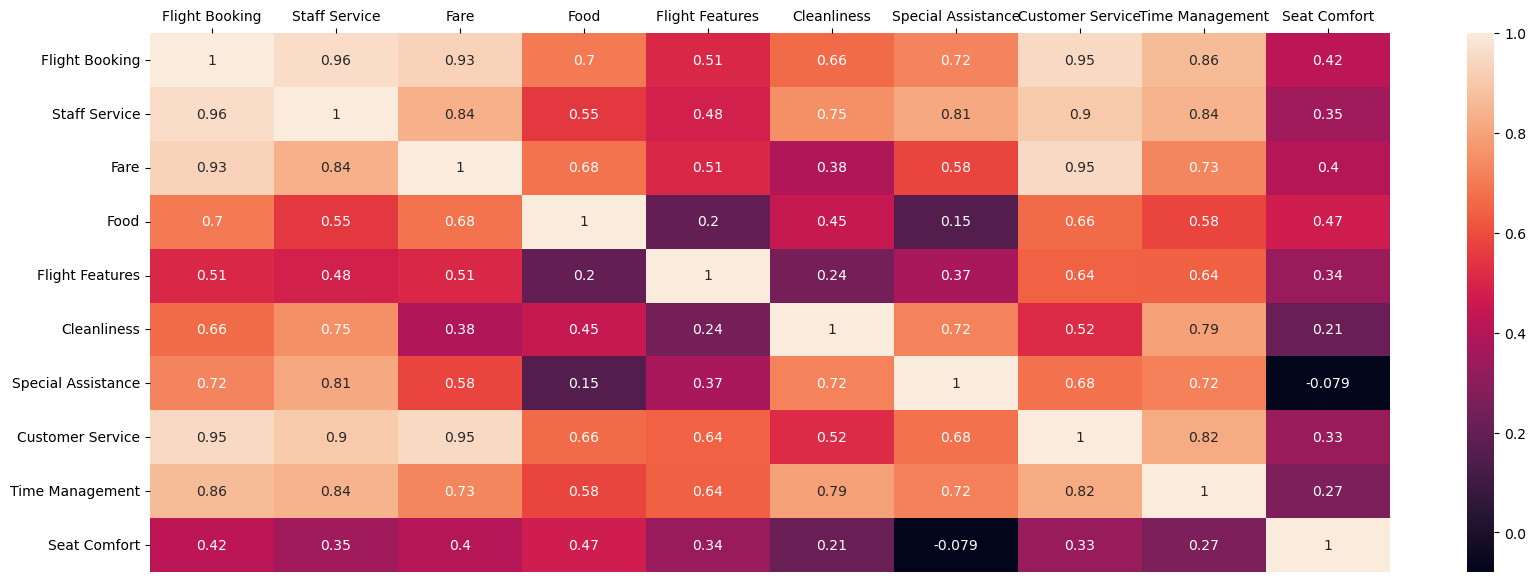

In [35]:
plt.figure(figsize=(20,7))
sns.heatmap(airlines.corr(),annot=True).xaxis.tick_top()

In [36]:
#pca analysis 
from sklearn.decomposition import PCA

for i in range(1,airlines.shape[1]+1):
    pca = PCA(n_components=i)
    pca.fit(airlines)
    exp_var = pca.explained_variance_ratio_
    print('The explained variance ratio for the component %d is '%(i),np.round(exp_var,4))

The explained variance ratio for the component 1 is  [0.6494]
The explained variance ratio for the component 2 is  [0.6494 0.1594]
The explained variance ratio for the component 3 is  [0.6494 0.1594 0.1055]
The explained variance ratio for the component 4 is  [0.6494 0.1594 0.1055 0.0469]
The explained variance ratio for the component 5 is  [0.6494 0.1594 0.1055 0.0469 0.0295]
The explained variance ratio for the component 6 is  [0.6494 0.1594 0.1055 0.0469 0.0295 0.0047]
The explained variance ratio for the component 7 is  [0.6494 0.1594 0.1055 0.0469 0.0295 0.0047 0.0035]
The explained variance ratio for the component 8 is  [0.6494 0.1594 0.1055 0.0469 0.0295 0.0047 0.0035 0.0008]
The explained variance ratio for the component 9 is  [6.494e-01 1.594e-01 1.055e-01 4.690e-02 2.950e-02 4.700e-03 3.500e-03
 8.000e-04 3.000e-04]
The explained variance ratio for the component 10 is  [6.494e-01 1.594e-01 1.055e-01 4.690e-02 2.950e-02 4.700e-03 3.500e-03
 8.000e-04 3.000e-04 0.000e+00]


In [38]:
pca = PCA(n_components=2)
components = pca.fit_transform(airlines)
pca_df = pd.DataFrame(components,columns=['PC1','PC2'],index=brand_names)
pca_df

,PC1,PC2
air india,-0.618842,-0.773278
air asia,2.591785,1.321122
air india express,-2.464936,-0.903719
alliance air,-2.867248,-0.747874
akasa,0.887496,0.271521
goair,-0.335417,1.823315
gofirst,-2.319157,0.714119
indigo,1.801487,-0.197234
spicejet,-0.146634,0.181756
vistara,3.471465,-1.689728


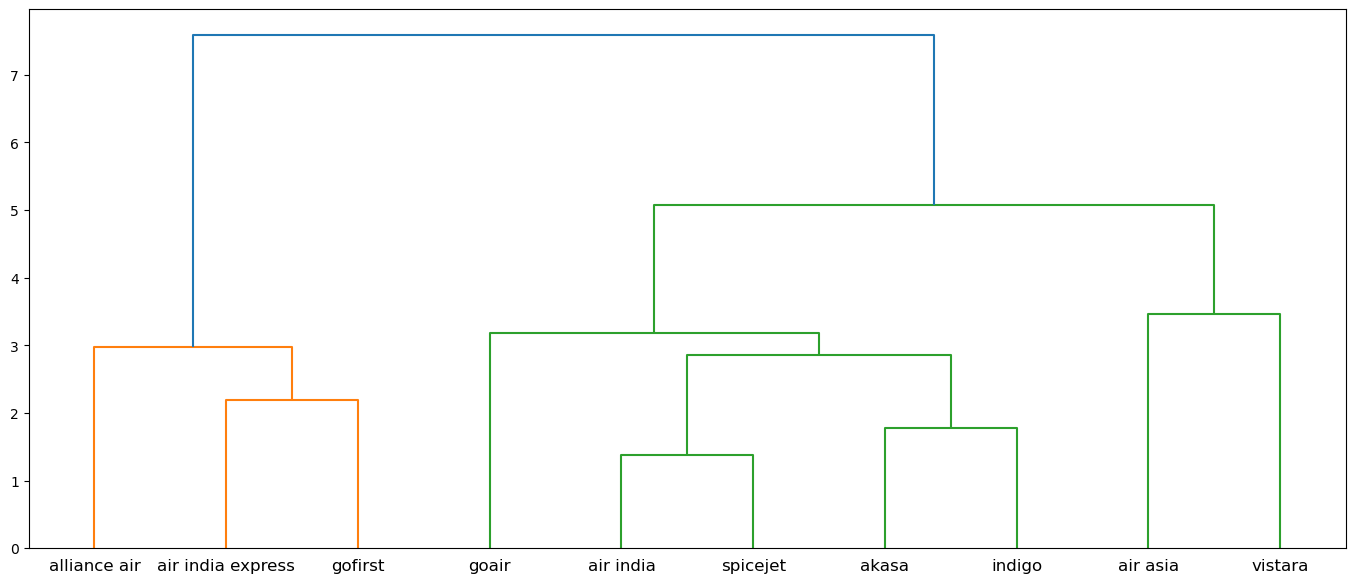

In [39]:
from scipy.cluster.hierarchy import linkage,dendrogram
plt.figure(figsize=(17,7))
linkage_data = linkage(airlines,method='ward',metric='euclidean')
dendrogram(linkage_data,labels=airlines.index)
plt.savefig("dendrogram.png", dpi=300) 
plt.show()

In [42]:
def biplot(score,coeff,brand_names,topics):
    x = score.iloc[:,0]
    y = score.iloc[:,1]
    scalex = 1 / (x.max()-x.min())
    scaley = 1 / (y.max()-y.min())
    
    fig,ax = plt.subplots(figsize=(15,10))
    ax.scatter(x*scalex,y*scaley)
    
    for i,txt in enumerate(brand_names):
        ax.annotate(txt,(x[i]*scalex,y[i]*scaley),xytext=(x[i]*scalex+0.007,y[i]*scaley-0.008))
        
    for i in range(10):
        ax.arrow(0,0,coeff[i,0],coeff[i,1],color='r',alpha=0.5)
        ax.text(coeff[i,0]+0.001,coeff[i,1]+0.008,topics[i],color='purple',ha='left',va='bottom')

    ax.set_title('PCA biplot')
    ax.set_xlim(-0.9,0.90)
    ax.set_ylim(-0.9,0.90)
    ax.set_xlabel('PC1 [64.4%]')
    ax.set_ylabel('PC2 [16.9%]')
    plt.axhline(y=0,color='k',linestyle='--',alpha=0.5)
    plt.axvline(x=0,color='k',linestyle='--',alpha=0.5)
    plt.savefig("pca_biplot.png", dpi=500) 
    plt.show()
    

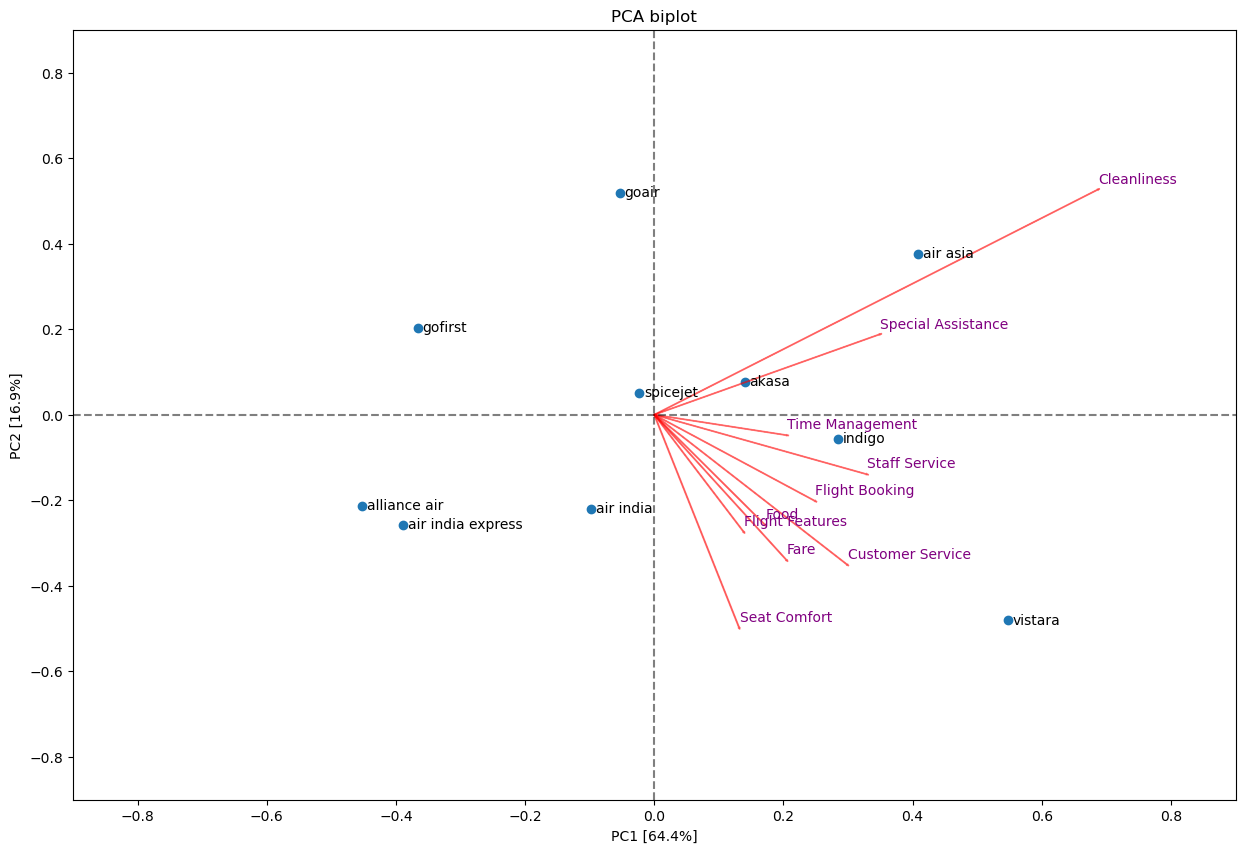

In [43]:
biplot(pca_df,pca.components_.T,brand_names,topics)

In [44]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_sq,p_value = calculate_bartlett_sphericity(airlines)
print('The chi-square value is %.4f and p-value are %.4f'%(chi_sq,p_value))

if p_value <0.05:
    print('The data is suitable for factor analysis')
else:
    print('The data is not suitable for factor analysis')

The chi-square value is 253.4990 and p-value are 0.0000
The data is suitable for factor analysis


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


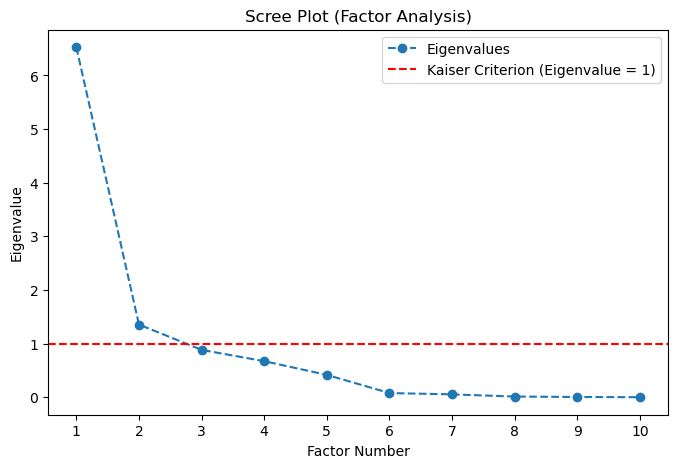

In [49]:
# Perform Factor Analysis (we initially extract all factors)
fa = FactorAnalyzer(n_factors=airlines.shape[1], rotation=None)
fa.fit(airlines)

# Get eigenvalues
eigenvalues, _ = fa.get_eigenvalues()

# Scree plot for Factor Analysis
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--', label="Eigenvalues")
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot (Factor Analysis)')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.axhline(y=1, color='r', linestyle='--', label="Kaiser Criterion (Eigenvalue = 1)")
plt.legend()
plt.show()

In [45]:
#factor biplot 
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=2,rotation='varimax')
fa.fit(airlines)
factor_scores = fa.transform(airlines)
factor_df = pd.DataFrame(factor_scores,columns=['Factor 1','Factor2'],index=airlines.index)
factor_df

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Factor 1,Factor2
air india,0.017506,0.112170
air asia,1.052580,0.549605
air india express,-1.593910,2.009471
alliance air,-2.400320,0.217185
akasa,0.392466,0.380537
goair,-0.653149,-0.782790
gofirst,0.369693,-2.069991
indigo,0.383177,0.203293
spicejet,1.336077,-2.562208
vistara,1.134829,1.997139


In [46]:
factor_loadings = pd.DataFrame(fa.loadings_, index=airlines.columns, columns=['Factor_1', 'Factor_2'])
factor_loadings

,Factor_1,Factor_2
Flight Booking,0.732365,0.679972
Staff Service,0.828013,0.505572
Fare,0.554558,0.726610
Food,0.243680,0.736060
Flight Features,0.392699,0.390885
Cleanliness,0.704246,0.214098
Special Assistance,1.012421,-0.059489
Customer Service,0.682322,0.675258
Time Management,0.785227,0.472829
Seat Comfort,-0.000260,0.611242


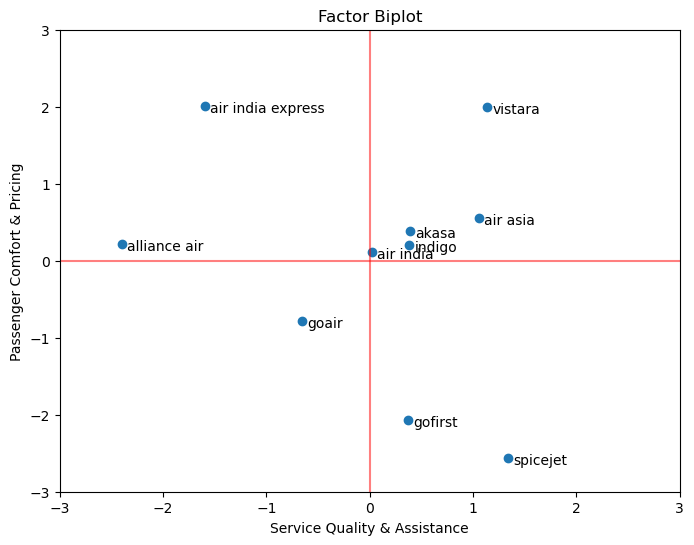

In [116]:
#factor biplot

# Create Factor Biplot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot Factor Scores (Airline points)
ax.scatter(factor_scores[:, 0], factor_scores[:, 1])

# Annotate each airline
for i, txt in enumerate(airlines.index):
    ax.annotate(txt, (factor_scores[i, 0]+0.05, factor_scores[i, 1]-0.08), fontsize=10)

# Formatting
ax.axhline(0, color='red' ,alpha=0.5)
ax.axvline(0, color='red',alpha=0.5)
ax.set_xlabel('Service Quality & Assistance')
ax.set_ylabel('Passenger Comfort & Pricing')
ax.set_xlim(-3.0,3.0)
ax.set_ylim(-3.0,3.0)
ax.set_title('Factor Biplot')
plt.savefig('Factor Biplot.jpg',dpi=500)
plt.show()


In [96]:
def sentiment_result(df):
    df['result'] = None
    for i in range(df.shape[0]):
        
        if df.iloc[i,12]>=1:
            df.iloc[i,-1] = 'Positive'
        elif df.iloc[i,12]<=-1:
            df.iloc[i,-1] = 'Negative'
        else:
            df.iloc[i,-1]='Neutral'
    return df


In [97]:
for i in [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]:
    i = sentiment_result(i)


In [98]:
df10.head()

,Review_id,Name,Date,Type_of_review,Rating,Sentence,cleaned_sentence,words,merged_words,pos_scores,neu_scores,neg_scores,compound_scores,result
0,1,Vikas Verma,26th July 2024,['Trip Verified'],1,[' extremely impolite and ill mannered cabin ...,extremely impolite and ill mannered cabin crew,"[extremely, impolite, ill, mannered, cabin, crew]",extremely impolite ill mannered cabin crew,0.000,0.401,0.599,-3.5795,Negative
1,1,Vikas Verma,26th July 2024,['Trip Verified'],1,instead of giving a reply to a simple question...,instead of giving a reply to a simple question...,"[instead, give, reply, simple, question, arrog...",instead give reply simple question arrogant cr...,0.000,0.503,0.497,-4.1800,Negative
2,1,Vikas Verma,26th July 2024,['Trip Verified'],1,even his colleagues were visibly disturbed by ...,even his colleagues were visibly disturbed by ...,"[even, colleague, visibly, disturb, behaviour]",even colleague visibly disturb behaviour,0.000,0.597,0.403,-2.0095,Negative
3,1,Vikas Verma,26th July 2024,['Trip Verified'],1,some people lack basic etiquettes and cannot b...,some people lack basic etiquettes and cannot b...,"[people, lack, basic, etiquette, not, trust, h...",people lack basic etiquette not trust hospital...,0.000,0.545,0.455,-3.0630,Negative
4,1,Vikas Verma,26th July 2024,['Trip Verified'],1,but does the airline care?,but does the airline care,"[but, airline, care]",but airline care,0.683,0.317,0.000,3.2430,Positive


In [99]:
def result_percent(df,flagmatrix):
    df['topics'] = None
    for i in range(df.shape[0]):
        for j in range(flagmatrix.shape[1]):
            if flagmatrix.iloc[i,j]==1:
                df.iloc[i,-1] = flagmatrix.columns[j]
    score = df.groupby('topics')['result'].value_counts()
    percentages = score / score.groupby(level = 0).sum()*100
    percentage = percentages.unstack()
    percentage.columns.name=None
    percentage.reset_index(inplace=True)
    
    return df,percentage

    

In [100]:
df1,percentage1 = result_percent(df1,df_flagmatrix1)
percentage1

,topics,Negative,Neutral,Positive
0,Cleanliness,40.000000,40.000000,20.000000
1,Customer Service,64.000000,20.000000,16.000000
2,Fare,35.714286,50.000000,14.285714
3,Flight Booking,38.524590,50.000000,11.475410
4,Flight Features,21.428571,42.857143,35.714286
5,Food,10.000000,70.000000,20.000000
6,Seat Comfort,NaN,60.000000,40.000000
7,Special Assistance,100.000000,NaN,NaN
8,Staff Service,39.473684,31.578947,28.947368
9,Time Management,58.620690,34.482759,6.896552


In [101]:
#percentage1 = percentage2 = percentage3 = percentage4 = percentage5 = percentage6 = percentage7 = percentage8 = percentage9 = percentage10 = 0
percentages =[]

for i,j in [(df1,df_flagmatrix1),(df2,df_flagmatrix2),(df3,df_flagmatrix3),(df4,df_flagmatrix4),(df5,df_flagmatrix5),\
        (df6,df_flagmatrix6),(df7,df_flagmatrix7),(df8,df_flagmatrix8),(df9,df_flagmatrix9),(df10,df_flagmatrix10)]:
    i,temp = result_percent(i,j)
    percentages.append(temp)

In [102]:
for i in range(10):
    percentages[i] = round(percentages[i],2)
    print('\t\t\t',brand_names[i])
    print(percentages[i],'\n\n\n')

			 air india
               topics  Negative  Neutral  Positive
0         Cleanliness     40.00    40.00     20.00
1    Customer Service     64.00    20.00     16.00
2                Fare     35.71    50.00     14.29
3      Flight Booking     38.52    50.00     11.48
4     Flight Features     21.43    42.86     35.71
5                Food     10.00    70.00     20.00
6        Seat Comfort       NaN    60.00     40.00
7  Special Assistance    100.00      NaN       NaN
8       Staff Service     39.47    31.58     28.95
9     Time Management     58.62    34.48      6.90 



			 air asia
               topics  Negative  Neutral  Positive
0         Cleanliness     46.79    21.15     32.05
1    Customer Service     35.50    41.45     23.05
2                Fare     20.58    41.88     37.55
3      Flight Booking     26.76    48.98     24.26
4     Flight Features     20.59    35.18     44.23
5                Food     20.04    47.61     32.35
6        Seat Comfort     22.07    43.87     34.06


In [103]:
percentages = [df.fillna(0) for df in percentages]
for i in percentages:
    print(i)

               topics  Negative  Neutral  Positive
0         Cleanliness     40.00    40.00     20.00
1    Customer Service     64.00    20.00     16.00
2                Fare     35.71    50.00     14.29
3      Flight Booking     38.52    50.00     11.48
4     Flight Features     21.43    42.86     35.71
5                Food     10.00    70.00     20.00
6        Seat Comfort      0.00    60.00     40.00
7  Special Assistance    100.00     0.00      0.00
8       Staff Service     39.47    31.58     28.95
9     Time Management     58.62    34.48      6.90
               topics  Negative  Neutral  Positive
0         Cleanliness     46.79    21.15     32.05
1    Customer Service     35.50    41.45     23.05
2                Fare     20.58    41.88     37.55
3      Flight Booking     26.76    48.98     24.26
4     Flight Features     20.59    35.18     44.23
5                Food     20.04    47.61     32.35
6        Seat Comfort     22.07    43.87     34.06
7  Special Assistance     22.50

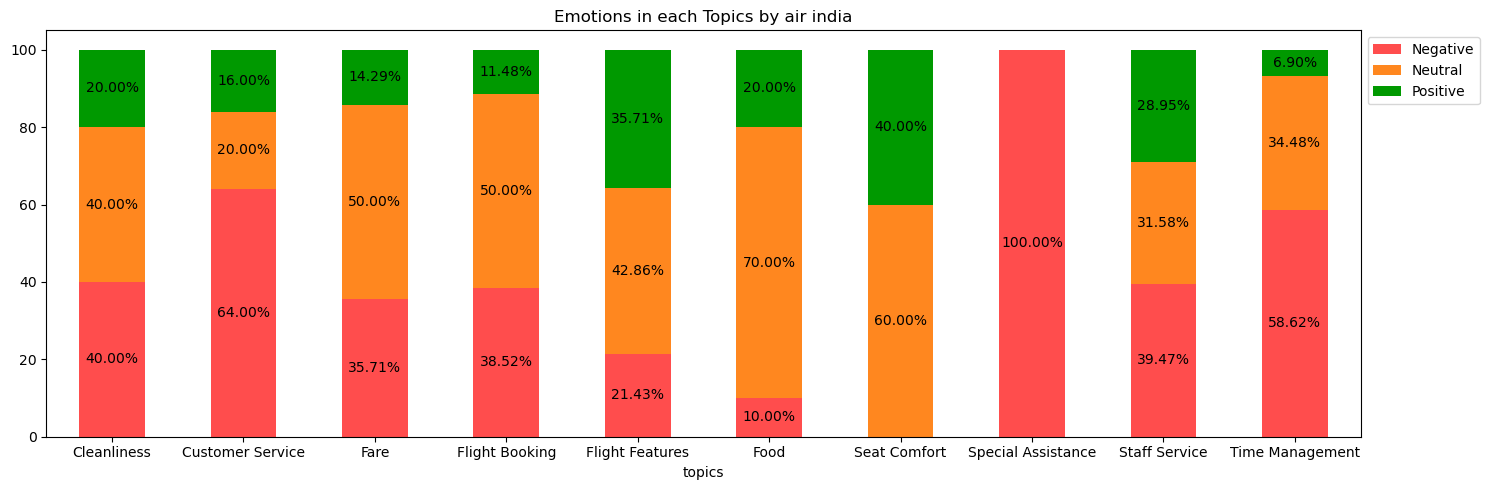

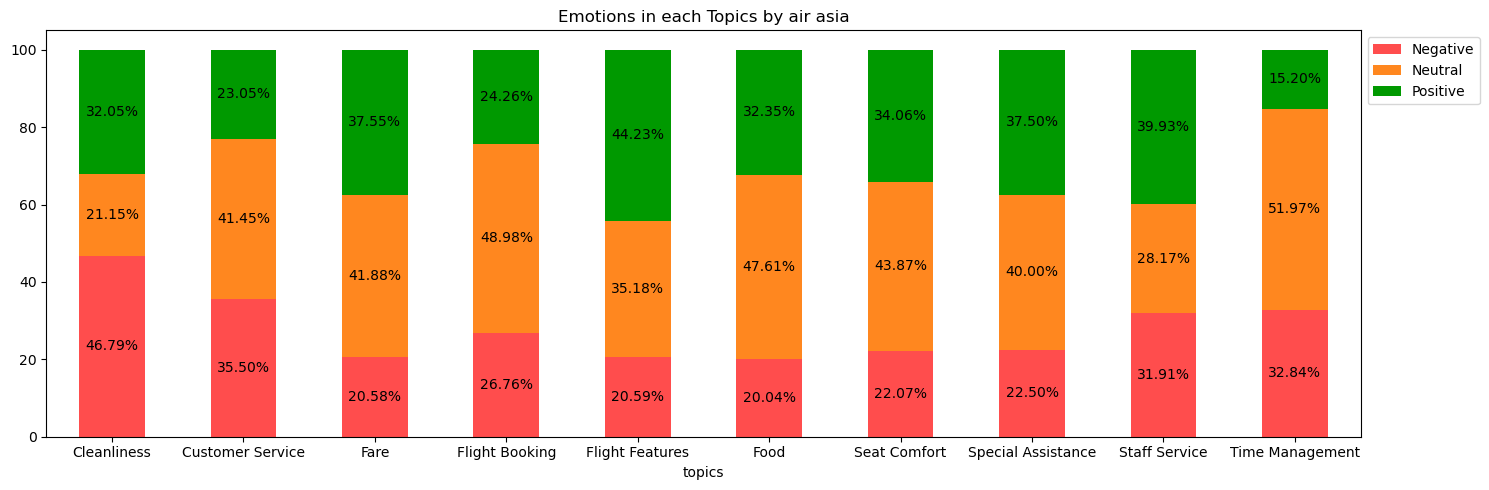

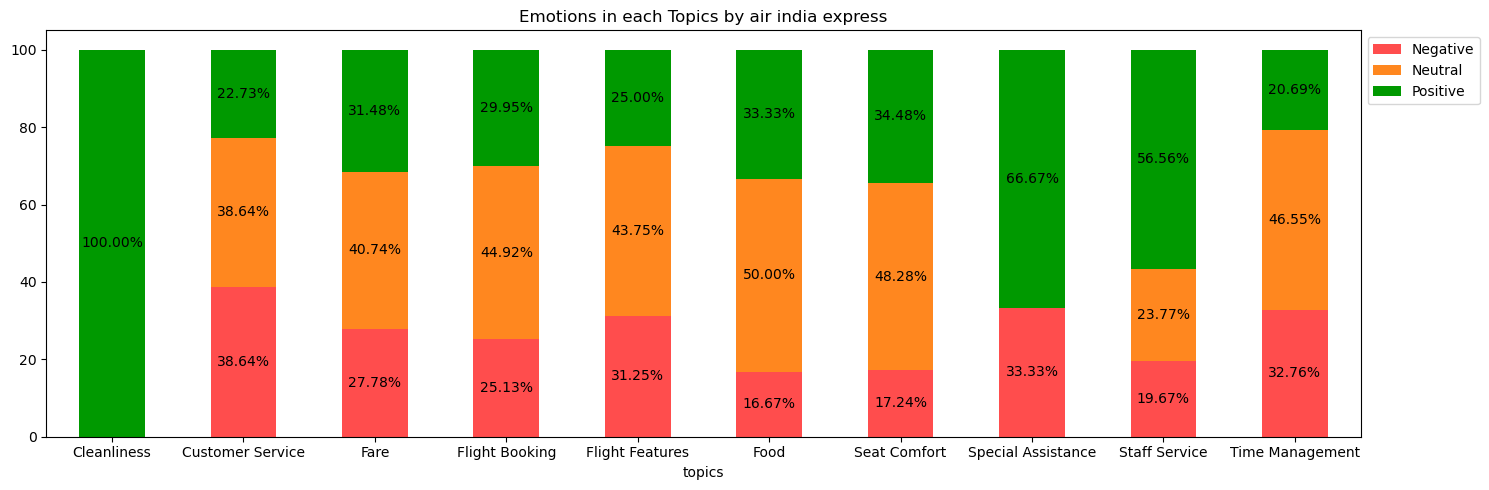

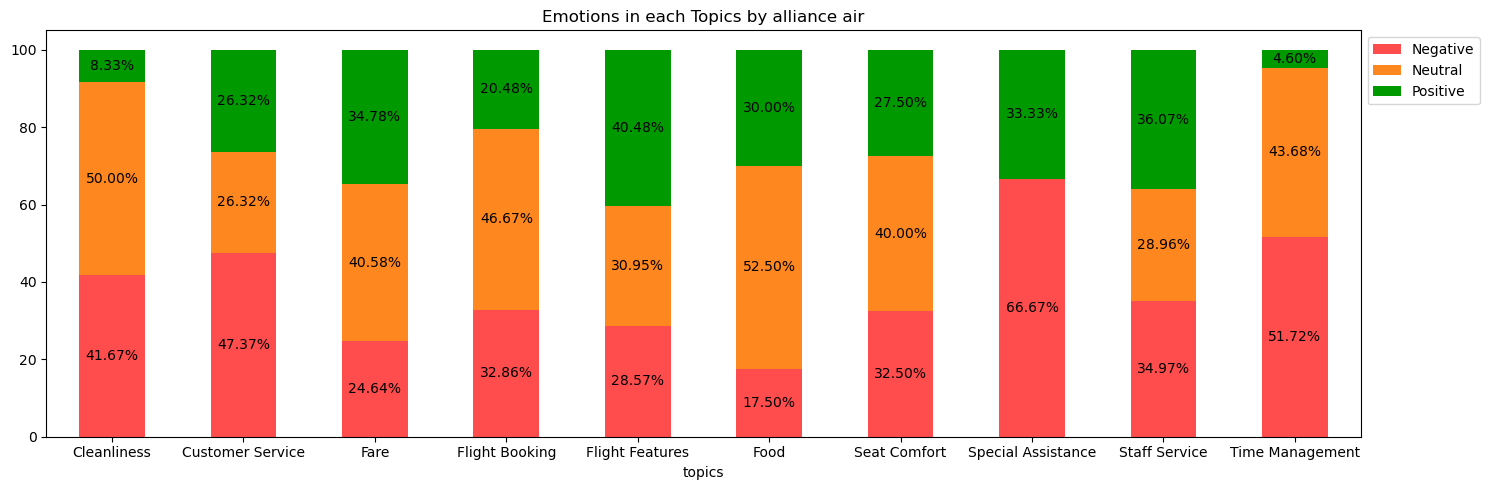

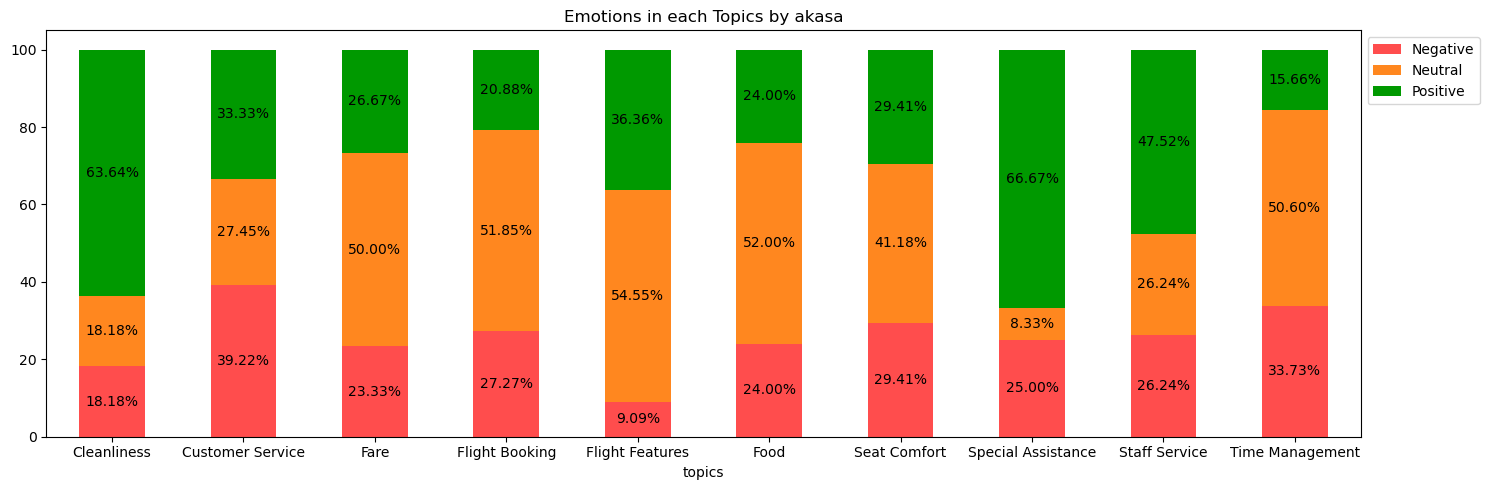

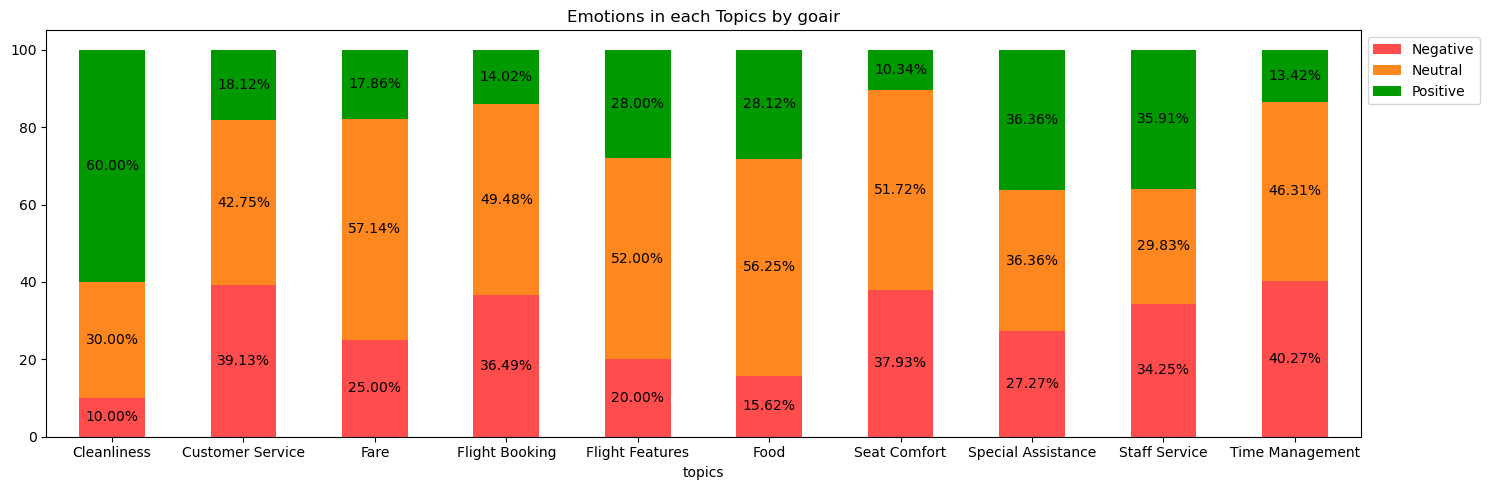

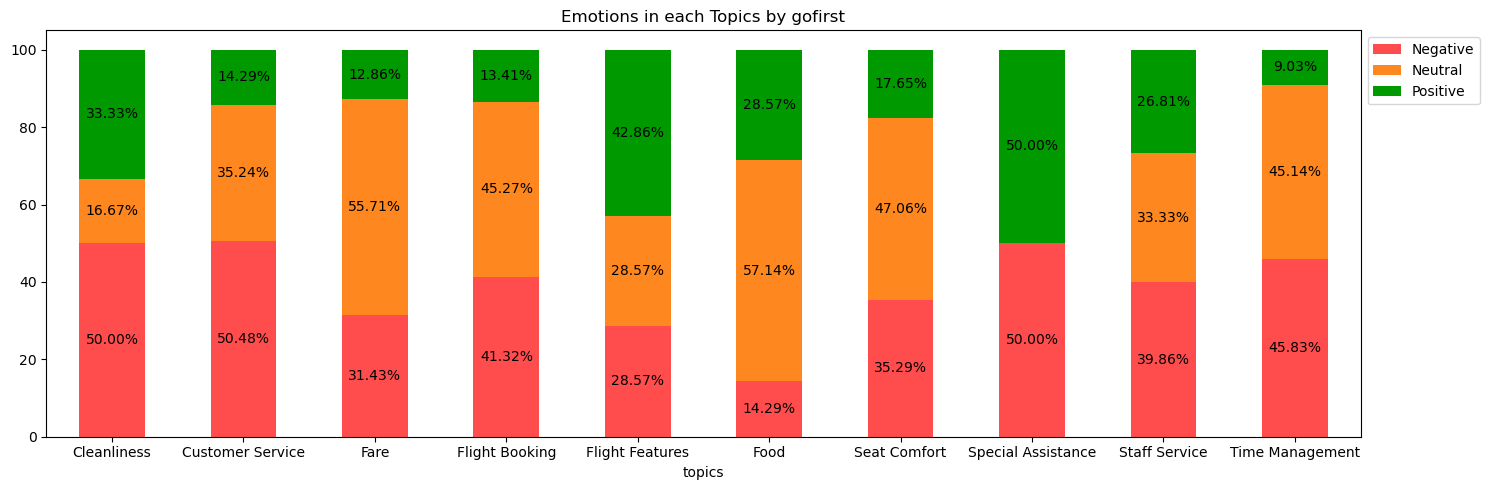

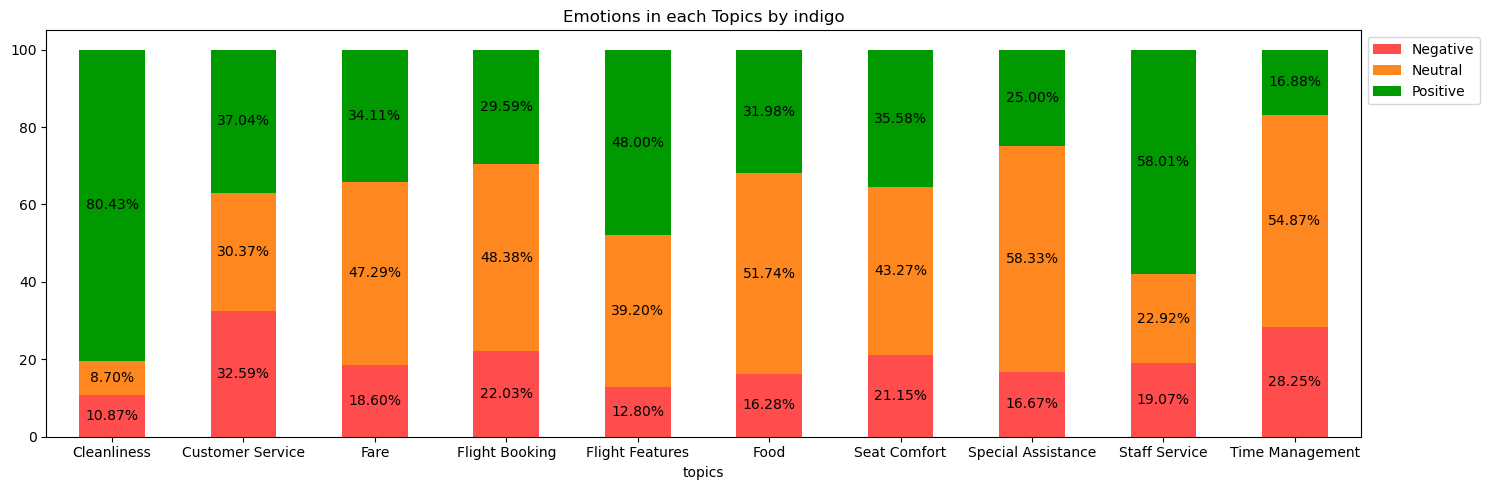

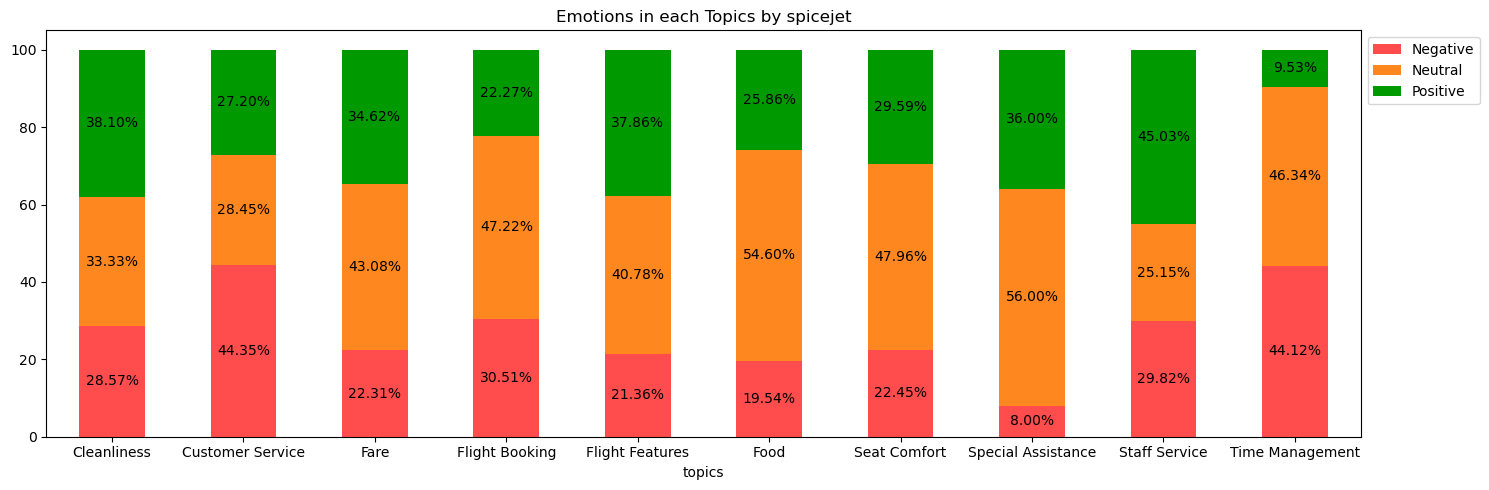

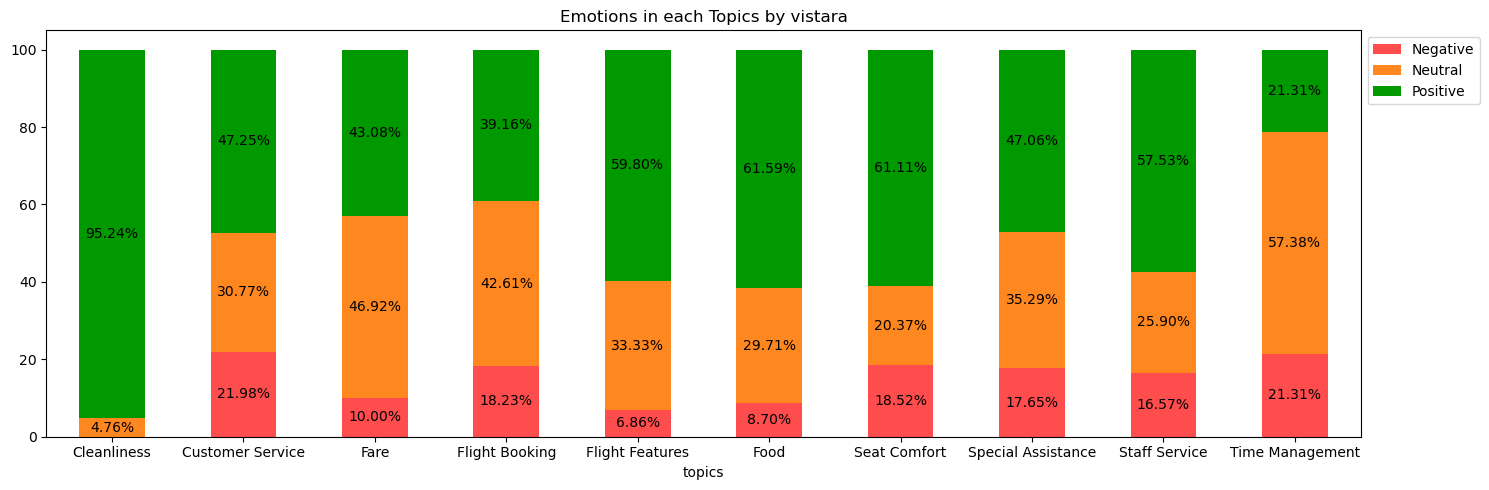

In [104]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
custom_colors = ['#ff4d4d','#ff871f','#009900']
cmap = ListedColormap(custom_colors)

for i in range(10):
    names = brand_names[i]
    percentages[i].plot(x='topics',kind='bar',stacked=True,title='Emotions in each Topics by Alliance Air',figsize=(15,5),
      colormap=cmap)
    for container in plt.gca().containers:
        plt.gca().bar_label(container,labels = [f"{v:.2f}%" if v else "" for v in container.datavalues],
        label_type='center', fontsize=10, color='black')
    
    plt.title(f"Emotions in each Topics by {brand_names[i]}")
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"{names}.png",dpi=300)
    plt.show()


In [105]:
#pn ratios 
def pn_ratios(df):
    df['PN ratio'] = 0.0
    for row in range(df.shape[0]):
        if df.iloc[row,3]==0 and df.iloc[row,1]==0:
            df.iloc[row,-1] = (df.iloc[row,3]+1)/(df.iloc[row,1]+1)
        elif df.iloc[row,3]==0:
            df.iloc[row,-1] = (df.iloc[row,3]+1)/df.iloc[row,1]
        elif df.iloc[row,1]==0:
            df.iloc[row,-1] = df.iloc[row,3]/(df.iloc[row,1]+1)
        else:
            df.iloc[row,-1]=df.iloc[row,3]/df.iloc[row,1]
            
    return df

In [106]:
for i in range(10):
    percentages[i] = pn_ratios(percentages[i])

In [107]:
for i in range(len(percentages)):
    print('\t\t\t',brand_names[i])
    print(percentages[i])

			 air india
               topics  Negative  Neutral  Positive   PN ratio
0         Cleanliness     40.00    40.00     20.00   0.500000
1    Customer Service     64.00    20.00     16.00   0.250000
2                Fare     35.71    50.00     14.29   0.400168
3      Flight Booking     38.52    50.00     11.48   0.298027
4     Flight Features     21.43    42.86     35.71   1.666356
5                Food     10.00    70.00     20.00   2.000000
6        Seat Comfort      0.00    60.00     40.00  40.000000
7  Special Assistance    100.00     0.00      0.00   0.010000
8       Staff Service     39.47    31.58     28.95   0.733468
9     Time Management     58.62    34.48      6.90   0.117707
			 air asia
               topics  Negative  Neutral  Positive  PN ratio
0         Cleanliness     46.79    21.15     32.05  0.684975
1    Customer Service     35.50    41.45     23.05  0.649296
2                Fare     20.58    41.88     37.55  1.824587
3      Flight Booking     26.76    48.98     24

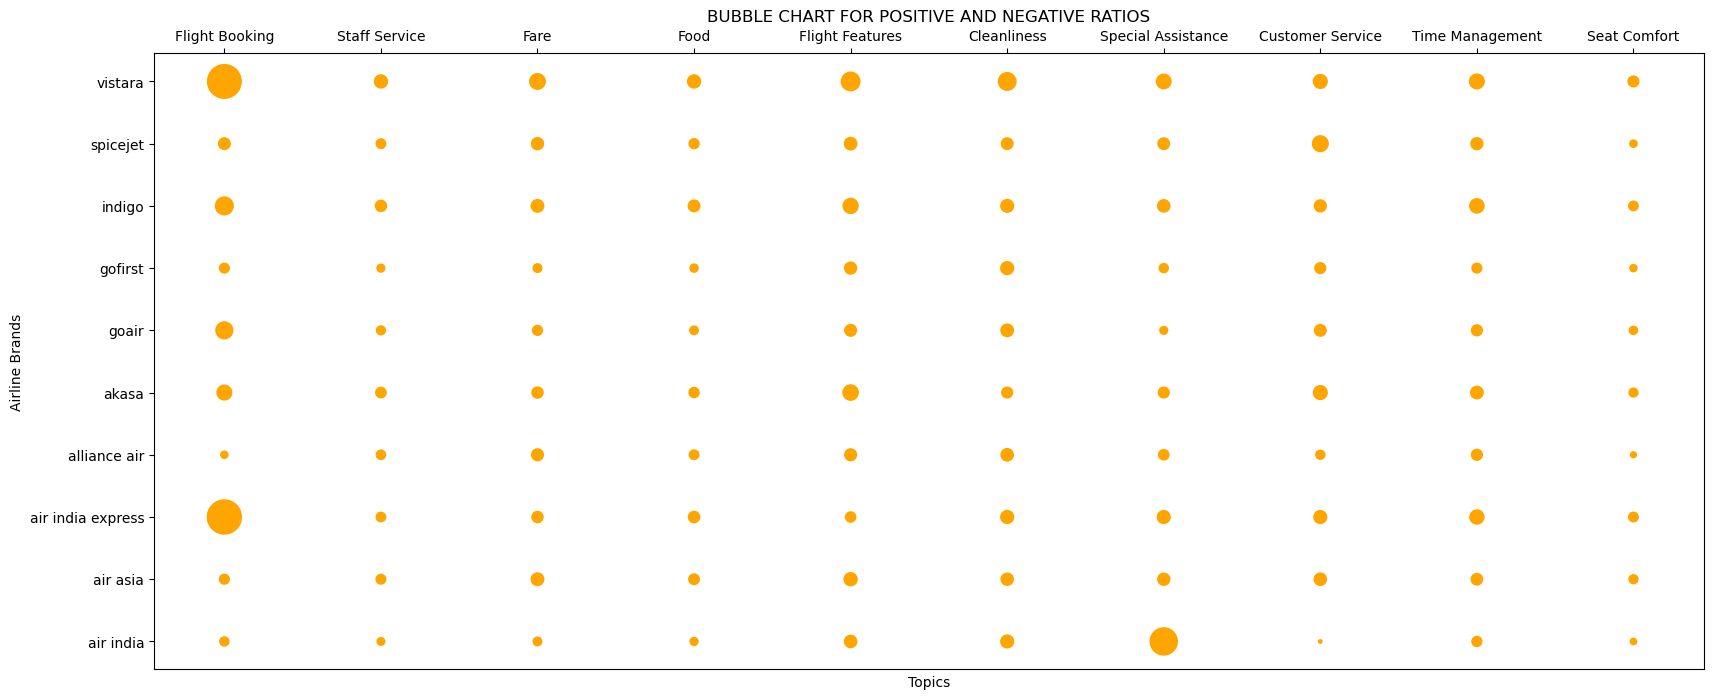

In [108]:
pn_ratios = np.concatenate([df['PN ratio'] for df in percentages]).astype('float64')
pn_ratios_scaled = np.sqrt(pn_ratios)
x_values = np.tile(np.arange(10), 10)  
y_values = np.repeat(np.arange(10), 10)
pn_ratios = pn_ratios_scaled*60

plt.figure(figsize=(20,8))
plt.scatter(x_values,y_values,s=pn_ratios,c='orange')
plt.gca().xaxis.tick_top()
plt.xticks(np.arange(10),topics)
plt.yticks(np.arange(10),brand_names)
plt.title('BUBBLE CHART FOR POSITIVE AND NEGATIVE RATIOS')
plt.xlabel('Topics')
plt.ylabel('Airline Brands')
plt.savefig('bubble_chart.png',dpi=300)
plt.show()
